In [ ]:
# !pip install pandas

In [ ]:
# !pip install matplotlib

In [ ]:
# !pip install seaborn

In [ ]:
# !pip install scikit-learn

In [ ]:
# !pip install hyperopt

In [ ]:
import os
cwd = os.getcwd()

In [ ]:
cwd

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 1600)
pd.set_option('display.max_columns', 1600)
import urllib.request, json 
from math import radians
import sklearn.neighbors
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
with urllib.request.urlopen("https://feeds.citibikenyc.com/stations/stations.json") as url:
    stations = json.loads(url.read().decode())
    stations = pd.DataFrame(stations['stationBeanList'])

In [3]:
stations.shape

(509, 18)

In [4]:
stations.head()

,id,stationName,availableDocks,totalDocks,latitude,longitude,statusValue,statusKey,availableBikes,stAddress1,stAddress2,city,postalCode,location,altitude,testStation,lastCommunicationTime,landMark
0,72,W 52 St & 11 Ave,32,39,40.77,-73.99,In Service,1,7,W 52 St & 11 Ave,,,,,,False,2016-01-22 04:30:15 PM,
1,79,Franklin St & W Broadway,0,33,40.72,-74.01,In Service,1,33,Franklin St & W Broadway,,,,,,False,2016-01-22 04:32:41 PM,
2,82,St James Pl & Pearl St,27,27,40.71,-74.00,In Service,1,0,St James Pl & Pearl St,,,,,,False,2016-01-22 04:29:41 PM,
3,83,Atlantic Ave & Fort Greene Pl,21,62,40.68,-73.98,In Service,1,40,Atlantic Ave & Fort Greene Pl,,,,,,False,2016-01-22 04:32:33 PM,
4,116,W 17 St & 8 Ave,19,39,40.74,-74.00,In Service,1,19,W 17 St & 8 Ave,,,,,,False,2016-01-22 04:32:32 PM,


In [5]:
collision_data=pd.read_csv('./Downloads\Motor_Vehicle_Collisions_-_Crashes.csv')
collision_data.columns = [col.replace(' ','_').lower() for col in collision_data.columns]

In [6]:
collision_data.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,12/04/2019,19:25,QUEENS,"11,429.00",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN
1,12/24/2019,18:45,NaN,NaN,nan,nan,NaN,VANWYCK EXPRESSWAY,LINDEN BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4266390,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,12/13/2019,16:45,BROOKLYN,"11,230.00",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
3,12/28/2019,4:00,NaN,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN
4,12/04/2019,11:54,MANHATTAN,"10,022.00",nan,nan,NaN,WEST 53 STREET,5 AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Other Vehicular,Other Vehicular,NaN,NaN,NaN,4252095,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN


In [7]:
collision_data.shape

(1762970, 29)

In [8]:
collision_data_2 = collision_data.loc[(collision_data.latitude.notnull() & collision_data.longitude.notnull())]

In [9]:
collision_data_2.shape

(1554134, 29)

In [10]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [11]:
collision_data_2.crash_date = lookup(collision_data_2.crash_date)

In [20]:
data_2018 = collision_data_2.loc[(collision_data_2.crash_date<pd.datetime(2019,1,1)) &
                                (collision_data_2.borough.notnull())]

In [21]:
data_2018_s = data_2018[['collision_id','borough','latitude','longitude']]

In [22]:
sample_df=data_2018_s.sample(frac=0.30, random_state=123)

In [23]:
X=sample_df[['collision_id','latitude','longitude']]#,'accident_reason'
y=sample_df[['borough']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 219052 rows
Test Set: 73018 rows


In [26]:
borough_nulls_model = RandomForestClassifier()
# define the ovr_nulls_model strategy
ovr_nulls_model = OneVsRestClassifier(borough_nulls_model)
# fit borough_nulls_model
ovr_nulls_model.fit(X_train, y_train)
# make predictions
yhat_ovr_nulls = ovr_nulls_model.predict(X_test)

In [27]:
print(accuracy_score(y_test,yhat_ovr_nulls))
print(classification_report(y_test,yhat_ovr_nulls))

0.99882220822263
               precision    recall  f1-score   support

        BRONX       1.00      1.00      1.00      9835
     BROOKLYN       1.00      1.00      1.00     22776
    MANHATTAN       1.00      1.00      1.00     17847
       QUEENS       1.00      1.00      1.00     19342
STATEN ISLAND       1.00      1.00      1.00      3218

     accuracy                           1.00     73018
    macro avg       1.00      1.00      1.00     73018
 weighted avg       1.00      1.00      1.00     73018



In [33]:
borough_nulls=collision_data_2.loc[collision_data_2.borough.isnull()][['collision_id','latitude','longitude']]

In [34]:
borough_nulls.reset_index(inplace=True,drop=True)

In [35]:
borough_nulls

,collision_id,latitude,longitude
0,4265714,40.77,-73.89
1,4250198,40.62,-73.96
2,4260921,40.68,-73.90
3,4260793,40.67,-73.81
4,4257488,40.78,-73.94
...,...,...,...
364311,3121398,40.61,-74.10
364312,2840713,40.75,-73.97
364313,2912120,40.89,-73.82
364314,3055638,40.77,-73.84


In [36]:
borough_preds=ovr_nulls_model.predict(borough_nulls)

In [37]:
borough_nulls['borough_pred']=borough_preds

In [38]:
borough_nulls

,collision_id,latitude,longitude,borough_pred
0,4265714,40.77,-73.89,QUEENS
1,4250198,40.62,-73.96,BROOKLYN
2,4260921,40.68,-73.90,BROOKLYN
3,4260793,40.67,-73.81,QUEENS
4,4257488,40.78,-73.94,MANHATTAN
...,...,...,...,...
364311,3121398,40.61,-74.10,STATEN ISLAND
364312,2840713,40.75,-73.97,MANHATTAN
364313,2912120,40.89,-73.82,BRONX
364314,3055638,40.77,-73.84,QUEENS


In [49]:
borough_nulls.collision_id.dtypes

dtype('int64')

In [48]:
collision_data_2.collision_id.dtypes

dtype('int64')

In [52]:
collision_data_2 = collision_data_2.merge(borough_nulls[['collision_id','borough_pred']],on=['collision_id'],how='left')

In [54]:
collision_data_2.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,borough_pred
0,2019-12-04,19:25,QUEENS,"11,429.00",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN,NaN
1,2019-12-13,16:45,BROOKLYN,"11,230.00",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
2,2019-12-28,4:00,NaN,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN,QUEENS
3,2019-12-27,16:50,QUEENS,"11,375.00",40.72,-73.85,"(40.721363, -73.84808)",AUSTIN STREET,69 ROAD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265377,Sedan,Motorcycle,NaN,NaN,NaN,NaN
4,2019-12-10,23:23,BROOKLYN,"11,236.00",40.63,-73.90,"(40.63489, -73.90114)",NaN,NaN,8902 AVENUE L,0.00,0.00,0,0,0,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4256278,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [57]:
collision_data_2.loc[collision_data_2.borough.isnull(),'borough_new']=collision_data_2['borough_pred']
collision_data_2.loc[collision_data_2.borough.notnull(),'borough_new']=collision_data_2['borough']
collision_data_2[['borough','borough_pred','borough_new']].head()

,borough,borough_pred,borough_new
0,QUEENS,NaN,QUEENS
1,BROOKLYN,NaN,BROOKLYN
2,NaN,QUEENS,QUEENS
3,QUEENS,NaN,QUEENS
4,BROOKLYN,NaN,BROOKLYN


In [58]:
collision_data_2.drop(['borough','borough_pred'],inplace=True,axis=1)
collision_data_2.rename(columns={'borough_new':'borough'},inplace=True)
collision_data_2.head()

,crash_date,crash_time,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,borough
0,2019-12-04,19:25,"11,429.00",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN,QUEENS
1,2019-12-13,16:45,"11,230.00",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN
2,2019-12-28,4:00,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN,QUEENS
3,2019-12-27,16:50,"11,375.00",40.72,-73.85,"(40.721363, -73.84808)",AUSTIN STREET,69 ROAD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265377,Sedan,Motorcycle,NaN,NaN,NaN,QUEENS
4,2019-12-10,23:23,"11,236.00",40.63,-73.90,"(40.63489, -73.90114)",NaN,NaN,8902 AVENUE L,0.00,0.00,0,0,0,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4256278,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN


In [59]:
collision_data_2.borough.isnull().sum()

0

### Answer 1

In [60]:
danger_cyclist=collision_data.groupby(['borough'],as_index=False).agg({'number_of_cyclist_injured':'sum',
                                                             'number_of_cyclist_killed':'sum'
                                                          }).sort_values(ascending=False,by='borough')

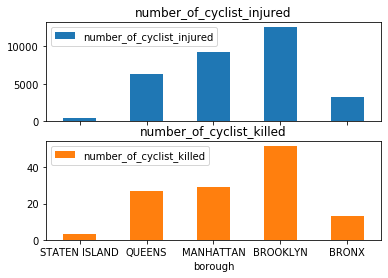

In [62]:
axes = danger_cyclist.plot.bar(x='borough',rot=0, subplots=True)
axes[1].legend(loc=2)

### Answer 2

### Calculating distance between each crash and nearest bike station

In [63]:
col_temp = collision_data_2[['collision_id','latitude','longitude']]

In [64]:
st_temp = stations[['id','latitude','longitude']]

In [65]:
col_temp[['lat_radians_C','long_radians_C']] = (
    np.radians(col_temp.loc[:,['latitude','longitude']])
)
st_temp[['lat_radians_S','long_radians_S']] = (
    np.radians(st_temp.loc[:,['latitude','longitude']])
)

In [66]:
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise
    (col_temp[['lat_radians_C','long_radians_C']],
     st_temp[['lat_radians_S','long_radians_S']])*3959
)
# Note that 3959 is the radius of the earth in miles


In [67]:
df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=col_temp['collision_id'], 
                 columns=st_temp['id'])
)

In [68]:
df_dist_matrix

id,72,79,82,83,116,119,120,127,128,137,143,144,146,147,150,151,152,153,157,160,161,164,167,168,173,174,195,212,216,217,223,224,225,228,229,232,233,236,237,238,239,241,242,243,244,245,247,248,249,250,251,252,253,254,257,258,259,260,261,262,263,264,265,266,267,268,270,274,275,276,278,279,280,281,282,284,285,289,291,293,295,296,297,298,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,319,320,321,322,323,324,325,326,327,328,329,330,331,332,334,335,336,337,339,340,341,342,343,344,345,346,347,348,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,372,373,375,376,377,379,380,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,405,406,407,408,409,410,411,412,414,415,416,417,418,419,420,421,422,423,426,427,428,430,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,453,454,455,456,457,458,459,460,461,462,463,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,536,537,539,540,545,546,2000,2001,2002,2003,2004,2005,2006,2008,2009,2010,2012,2017,2021,2022,2023,3002,3041,3042,3043,3044,3046,3047,3048,3049,3050,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082,3083,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125,3126,3127,3128,3129,3131,3132,3134,3135,3136,3137,3138,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148,3150,3151,3152,3153,3154,3155,3156,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3175,3176,3177,3178,3179,3180,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199,3200,3201,3202,3203,3205,3206,3207,3209,3210,3211,3212,3213,3214,3215,3216,3217,3220,3221,3222,3223,3224,3225,3226,3229,3230,3231,3232,3233,3235,3236,3237,3238,3241,3242,3243,3244
collision_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4252615,13.39,13.42,13.05,11.91,13.34,11.92,11.00,13.50,13.27,12.22,12.74,12.05,13.53,13.64,12.08,12.94,13.53,12.47,12.89,12.24,13.03,11.92,12.14,12.95,12.78,12.05,13.59,13.63,12.81,12.72,13.21,13.33,13.68,12.03,12.79,12.55,12.57,12.46,12.45,13.64,12.11,11.79,11.68,12.03,11.28,11.88,13.44,13.48,13.54,12.87,12.82,13.08,12.91,13.08,13.20,11.48,13.69,13.66,12.21,11.71,12.87,13.43,12.64,11.83,12.76,13.05,11.60,11.90,11.33,13.61,12.26,13.13,12.91,12.32,11.38,13.36,12.70,10.99,12.26,12.66,12.68,12.90,12.50,12.06,12.61,12.23,11.92,13.07,13.76,11.92,13.32,12.52,12.97,13.73,12.53,12.43,12.51,11.37,12.58,13.40,13.39,12.15,13.54,13.35,12.51,12.60,12.37,12.11,12.41,12.32,13.92,13.60,13.61,13.35,12.62,11.97,13.13,12.82,13.09,13.48,11.76,12.41,11.82,12.02,11.48,10.73,13.05,13.52,13.58,13.18,12.38,13.36,12.47,11.79,11.10,13.04,12.15,12.72,13.53,12.19,13.51,12.63,12.77,13.94,11.03,11.16,11.45,12.04,13.25,13.17,10.88,10.66,12.95,13.42,13.38,12.93,13.33,12.77,13.20,11.33,11.80,13.18,13.29,13.52,11.22,12.26,12.72,12.40,12.04,11.94,12.28,10.88,11.54,13.08,11.27,12.12,12.55,12.70,12.62,13.65,12.86,12.60,12.73,10.82,12.30,11.87,12.75,12.40,13.53,11.69,13.58,12.13,11.68,11.53,11.56,13.17,13.01,13.75,13.78,12.46,12.34,12.26,12.12,13.47,12.96,10

In [69]:
nearest_station_id = pd.DataFrame(df_dist_matrix.idxmin(axis=1))

In [70]:
nearest_station_dist = pd.DataFrame(df_dist_matrix.min(axis=1))

In [71]:
nearest_station_id.columns=['id']

In [72]:
nearest_station_dist.columns=['distance']

In [73]:
nearest_station_df = nearest_station_id.merge(nearest_station_dist,on='collision_id')

In [74]:
collision_data_2.shape

(1554134, 29)

In [75]:
collision_data_2.head()

,crash_date,crash_time,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,borough
0,2019-12-04,19:25,"11,429.00",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN,QUEENS
1,2019-12-13,16:45,"11,230.00",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN
2,2019-12-28,4:00,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN,QUEENS
3,2019-12-27,16:50,"11,375.00",40.72,-73.85,"(40.721363, -73.84808)",AUSTIN STREET,69 ROAD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265377,Sedan,Motorcycle,NaN,NaN,NaN,QUEENS
4,2019-12-10,23:23,"11,236.00",40.63,-73.90,"(40.63489, -73.90114)",NaN,NaN,8902 AVENUE L,0.00,0.00,0,0,0,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4256278,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN


In [76]:
collision_data_2=collision_data_2.merge(nearest_station_df,on='collision_id')

In [77]:
collision_data_2.head()

,crash_date,crash_time,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,borough,id,distance
0,2019-12-04,19:25,"11,429.00",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN,QUEENS,3042,9.56
1,2019-12-13,16:45,"11,230.00",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN,396,3.18
2,2019-12-28,4:00,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN,QUEENS,3123,2.73
3,2019-12-27,16:50,"11,375.00",40.72,-73.85,"(40.721363, -73.84808)",AUSTIN STREET,69 ROAD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265377,Sedan,Motorcycle,NaN,NaN,NaN,QUEENS,3221,4.82
4,2019-12-10,23:23,"11,236.00",40.63,-73.90,"(40.63489, -73.90114)",NaN,NaN,8902 AVENUE L,0.00,0.00,0,0,0,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4256278,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN,3042,3.43


In [78]:
collision_station_comb = collision_data_2.merge(stations[['id','stationName','availableDocks',
                                 'totalDocks','latitude','longitude',
                                 'statusValue','statusKey','availableBikes']],on='id',how='left')

In [79]:
collision_station_comb.head()

,crash_date,crash_time,zip_code,latitude_x,longitude_x,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,borough,id,distance,stationName,availableDocks,totalDocks,latitude_y,longitude_y,statusValue,statusKey,availableBikes
0,2019-12-04,19:25,"11,429.00",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN,QUEENS,3042,9.56,Fulton St & Utica Ave,2,19,40.68,-73.93,In Service,1,16
1,2019-12-13,16:45,"11,230.00",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN,396,3.18,Lefferts Pl & Franklin Ave,22,25,40.68,-73.96,In Service,1,3
2,2019-12-28,4:00,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN,QUEENS,3123,2.73,31 St & Thomson Ave,7,27,40.74,-73.94,In Service,1,20
3,2019-12-27,16:50,"11,375.00",40.72,-73.85,"(40.721363, -73.84808)",AUSTIN STREET,69 ROAD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265377,Sedan,Motorcycle,NaN,NaN,NaN,QUEENS,3221,4.82,47 Ave & 31 St,12,27,40.74,-73.94,In Service,1,15
4,2019-12-10,23:23,"11,236.00",40.63,-73.90,"(40.63489, -73.90114)",NaN,NaN,8902 AVENUE L,0.00,0.00,0,0,0,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4256278,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN,3042,3.43,Fulton St & Utica Ave,2,19,40.68,-73.93,In Service,1,16


In [80]:
collision_station_comb.shape

(1554134, 39)

In [81]:
collision_station_comb['vehicle_type_code_1'] = collision_station_comb['vehicle_type_code_1'].str.lower()
collision_station_comb['vehicle_type_code_2'] = collision_station_comb['vehicle_type_code_2'].str.lower()
collision_station_comb['vehicle_type_code_3'] = collision_station_comb['vehicle_type_code_3'].str.lower()

In [82]:
collision_station_comb['vehicle_type_code_1'].fillna('unknown',axis=0,inplace=True)
collision_station_comb['vehicle_type_code_2'].fillna('unknown',axis=0,inplace=True)
collision_station_comb['vehicle_type_code_3'].fillna('unknown',axis=0,inplace=True)

In [83]:
collision_station_comb['vehicle_type_code_1'].replace('minibike','minicycle',inplace=True)
collision_station_comb['vehicle_type_code_2'].replace('minibike','minicycle',inplace=True)
collision_station_comb['vehicle_type_code_3'].replace('minibike','minicycle',inplace=True)

In [84]:
collision_station_comb['vehicle_type_code_1'].replace('motorbike','motorcycle',inplace=True)
collision_station_comb['vehicle_type_code_2'].replace('motorbike','motorcycle',inplace=True)
collision_station_comb['vehicle_type_code_3'].replace('motorbike','motorcycle',inplace=True)

In [85]:
df = pd.DataFrame(collision_station_comb.loc[(collision_station_comb.vehicle_type_code_1.str.contains('bike|bicycle')) |
                          (collision_station_comb.vehicle_type_code_2.str.contains('bike|bicycle')) |
                           (collision_station_comb.vehicle_type_code_3.str.contains('bike|bicycle')) ].groupby([
    'id','borough'],as_index=False).agg({'collision_id':'count',
                                         'number_of_cyclist_injured':'sum',
                                         'number_of_cyclist_killed':'sum',
                                         'number_of_persons_injured':'sum',
                                         'number_of_persons_killed':'sum'}).sort_values(ascending=False,by='collision_id'))

In [86]:
df.shape

(503, 7)

In [87]:
df.head()

,id,borough,collision_id,number_of_cyclist_injured,number_of_cyclist_killed,number_of_persons_injured,number_of_persons_killed
455,3157,BRONX,3837,3039,17,"3,206.00",17.00
422,3123,QUEENS,3373,2822,5,"2,948.00",5.00
242,467,BROOKLYN,3372,2776,10,"2,921.00",10.00
334,3042,BROOKLYN,2947,2443,11,"2,567.00",11.00
470,3168,MANHATTAN,2507,1860,4,"1,970.00",4.00


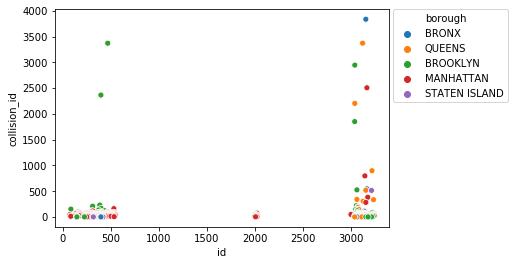

<Figure size 1080x1080 with 0 Axes>

In [88]:
sns.scatterplot(data=df, x='id', y='collision_id', hue='borough')
#plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.figure(figsize=(15,15))
plt.show()

In [89]:
df.sort_values(by='collision_id')

,id,borough,collision_id,number_of_cyclist_injured,number_of_cyclist_killed,number_of_persons_injured,number_of_persons_killed
12,146,BROOKLYN,1,1,0,1.00,0.00
105,317,QUEENS,1,1,0,1.00,0.00
357,3064,BRONX,1,1,0,1.00,0.00
207,427,MANHATTAN,1,0,0,0.00,0.00
199,417,STATEN ISLAND,1,1,0,1.00,0.00
102,317,BRONX,1,1,0,1.00,0.00
103,317,BROOKLYN,1,1,0,1.00,0.00
178,396,QUEENS,1,1,0,1.00,0.00
481,3180,BROOKLYN,1,1,0,1.00,0.00
332,3041,QUEENS,1,1,0,1.00,0.00


In [90]:
df_2 = df.groupby(['borough'],as_index=False).agg({'collision_id':'sum',
'number_of_cyclist_injured':'sum',
'number_of_cyclist_killed':'sum',
'number_of_persons_injured':'sum',
'number_of_persons_killed':'sum'})

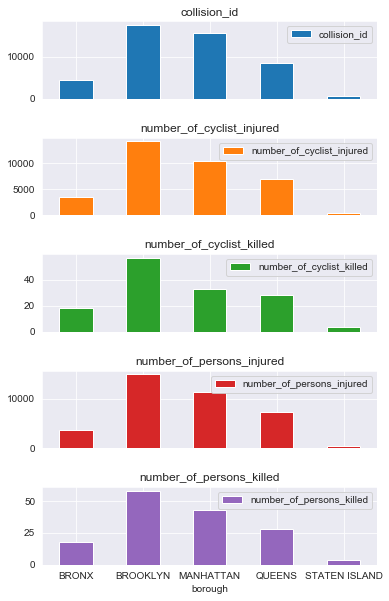

In [91]:
#df.groupby(['borough'],as_index=False).sum().plot(kind='bar',x='borough',subplots=True,rot=0)
sns.set_style('darkgrid')
df_2.plot(kind='bar',x='borough',subplots=True,rot=0,figsize=(6,10))#,layout=(2,3)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [92]:
df_ovr = collision_station_comb.groupby([
    'id','borough'],as_index=False).agg({'collision_id':'count',
                                         'number_of_cyclist_injured':'sum',
                                         'number_of_cyclist_killed':'sum',
                                         'number_of_persons_injured':'sum',
                                         'number_of_persons_killed':'sum'}).sort_values(ascending=False,by='collision_id')

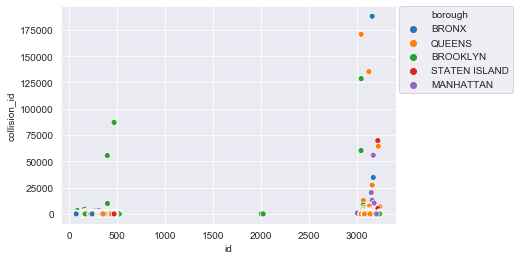

<Figure size 1080x1080 with 0 Axes>

In [93]:
sns.scatterplot(data=df_ovr, x='id', y='collision_id', hue='borough')
#plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.figure(figsize=(15,15))
plt.show()

In [95]:
df_ovr.sort_values(by='collision_id',ascending=False).head()

,id,borough,collision_id,number_of_cyclist_injured,number_of_cyclist_killed,number_of_persons_injured,number_of_persons_killed
588,3157,BRONX,187960,3246,18,"58,693.00",268.00
429,3042,QUEENS,170829,1916,11,"55,555.00",243.00
548,3123,QUEENS,135337,2889,5,"34,629.00",202.00
427,3042,BROOKLYN,128640,2560,12,"47,404.00",201.00
314,467,BROOKLYN,86982,2859,12,"22,849.00",106.00


### Additional Insights

In [97]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [98]:
collision_station_comb.crash_date = lookup(collision_station_comb.crash_date)

In [99]:
collision_station_comb['crash_month']=collision_station_comb.crash_date.dt.month
collision_station_comb['crash_year']=collision_station_comb.crash_date.dt.year
collision_station_comb['crash_day']=collision_station_comb.crash_date.dt.weekday_name
collision_station_comb['crash_week']=collision_station_comb.crash_date.dt.week
collision_station_comb['crash_day_of_week']=collision_station_comb.crash_date.dt.dayofweek

collision_station_comb.loc[collision_station_comb.crash_day_of_week.isin([5,6]),'is_weekend']=1
collision_station_comb.loc[~collision_station_comb.crash_day_of_week.isin([5,6]),'is_weekend']=0

In [100]:
collision_station_comb.isnull().sum()

crash_date                             0
crash_time                             0
zip_code                          364510
latitude_x                             0
longitude_x                            0
location                               0
on_street_name                    302103
cross_street_name                 541259
off_street_name                  1314074
number_of_persons_injured             16
number_of_persons_killed              28
number_of_pedestrians_injured          0
number_of_pedestrians_killed           0
number_of_cyclist_injured              0
number_of_cyclist_killed               0
number_of_motorist_injured             0
number_of_motorist_killed              0
contributing_factor_vehicle_1       4455
contributing_factor_vehicle_2     224443
contributing_factor_vehicle_3    1450504
contributing_factor_vehicle_4    1531644
contributing_factor_vehicle_5    1548173
collision_id                           0
vehicle_type_code_1                    0
vehicle_type_cod

In [101]:
collision_station_comb.contributing_factor_vehicle_1.fillna('Unspecified',inplace=True,axis=0)

In [102]:
collision_station_comb.number_of_persons_killed.fillna(0,inplace=True,axis=0)

In [103]:
collision_station_comb.number_of_persons_injured.fillna(0,inplace=True,axis=0)

In [104]:
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Unspecified","accident_reason"]="unknown"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Driver Inattention/Distraction","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Failure to Yield Right-of-Way","accident_reason"]="breaking_traffic_rules"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Backing Unsafely","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Other Vehicular","accident_reason"]="other_vehicle_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Following Too Closely","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Turning Improperly","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Passing Too Closely","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Passing or Lane Usage Improper","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Fatigued/Drowsy","accident_reason"]="driver_fatigue"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Traffic Control Disregarded","accident_reason"]="breaking_traffic_rules"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Driver Inexperience","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Lost Consciousness","accident_reason"]="driver_sick"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Unsafe Lane Changing","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Prescription Medication","accident_reason"]="driver_sick"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Alcohol Involvement","accident_reason"]="alcohal_or_drugs"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Pavement Slippery","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Unsafe Speed","accident_reason"]="breaking_traffic_rules"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Oversized Vehicle","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="View Obstructed/Limited","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Physical Disability","accident_reason"]="driver_sick"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Outside Car Distraction","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Reaction to Uninvolved Vehicle","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Passenger Distraction","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Aggressive Driving/Road Rage","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Pedestrian/Bicyclist/Other Pedestrian Error/Confusion","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Brakes Defective","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Fell Asleep","accident_reason"]="driver_fatigue"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Glare","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Obstruction/Debris","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Failure to Keep Right","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Illness","accident_reason"]="driver_sick"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Other Electronic Device","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Steering Failure","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Pavement Defective","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Reaction to Other Uninvolved Vehicle","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Tire Failure/Inadequate","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Animals Action","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Driverless/Runaway Vehicle","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Illnes","accident_reason"]="driver_sick"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Accelerator Defective","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Lane Marking Improper/Inadequate","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Traffic Control Device Improper/Non-Working","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Drugs (illegal)","accident_reason"]="alcohal_or_drugs"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Drugs (Illegal)","accident_reason"]="alcohal_or_drugs"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Cell Phone (hand-Held)","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Cell Phone (hands-free)","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Tow Hitch Defective","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Other Lighting Defects","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Headlights Defective","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Vehicle Vandalism","accident_reason"]="external_factor"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Tinted Windows","accident_reason"]="driver_fault"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Cell Phone (hand-held)","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Eating or Drinking","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Using On Board Navigation Device","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Shoulders Defective/Improper","accident_reason"]="driver_sick"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Windshield Inadequate","accident_reason"]="vehicle_malfunction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="80","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Texting","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="Listening/Using Headphones","accident_reason"]="driver_distraction"
collision_station_comb.loc[
    collision_station_comb.contributing_factor_vehicle_1=="1","accident_reason"]="driver_distraction"


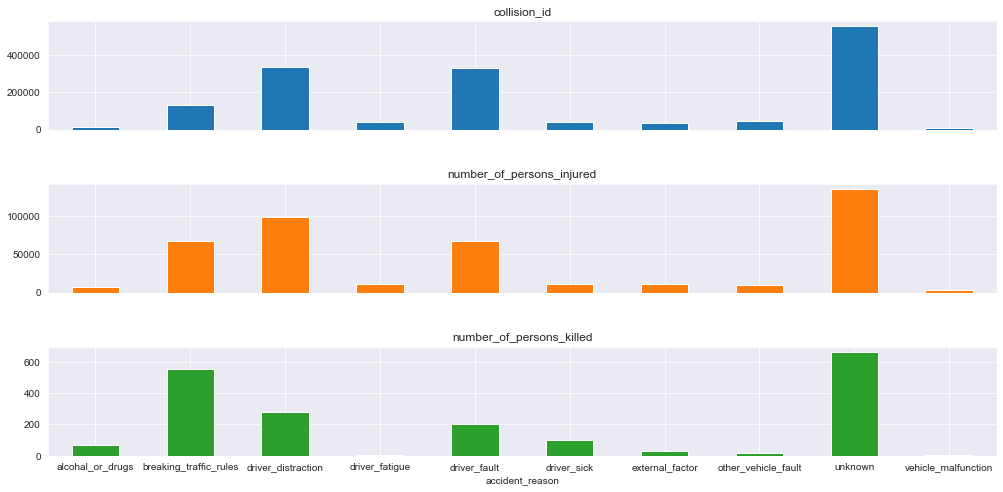

In [105]:
collision_station_comb.groupby(['accident_reason'],as_index=False).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   }).plot.bar(x='accident_reason',
                                                                    subplots=True,rot=0,figsize=(17,8),legend=False)
plt.subplots_adjust(hspace=0.5)
plt.show()

- Mostly Collisions occur due to Driver's Fault or Driver's Distraction
- However, Collisions caused because Breaking of Traffic Rules result in more deaths

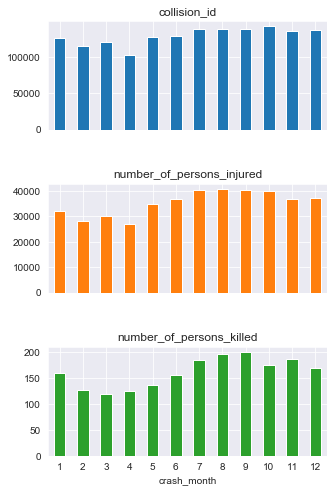

In [106]:
collision_station_comb.groupby(['crash_month'],as_index=False).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   }).plot.bar(x='crash_month',
                                                                              subplots=True,rot=0,figsize=(5,8),legend=False)
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.subplots_adjust(hspace=0.5)
plt.show()

- There are more accidents in later half of the year

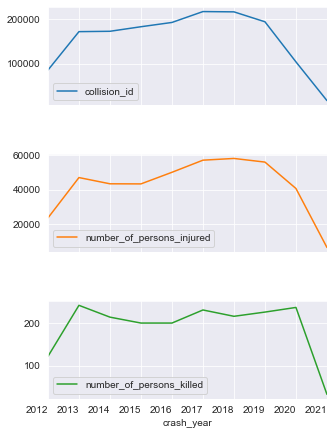

In [107]:
collision_station_comb.groupby(['crash_year'],as_index=False).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   }).plot(x='crash_year',
                                                                              subplots=True,rot=0,figsize=(5,8))
plt.subplots_adjust(hspace=0.5)
plt.show()

- Accidents increased over the year until 2019.There's a significant drop in 2020 due to Covid 19 Outbreak

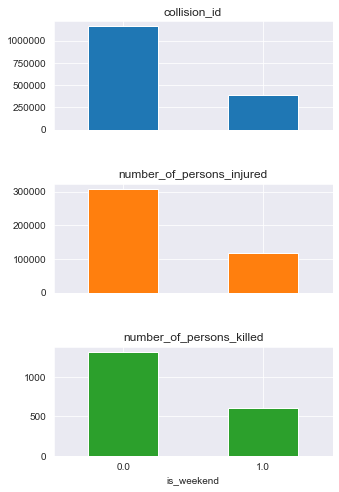

In [108]:
collision_station_comb.groupby(['is_weekend'],as_index=False).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   }).plot.bar(x='is_weekend',
                                                                              subplots=True,rot=0,figsize=(5,8),legend=False)
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.subplots_adjust(hspace=0.5)
plt.show()

- Mostly accidents occur in weekdays probably because these are working days

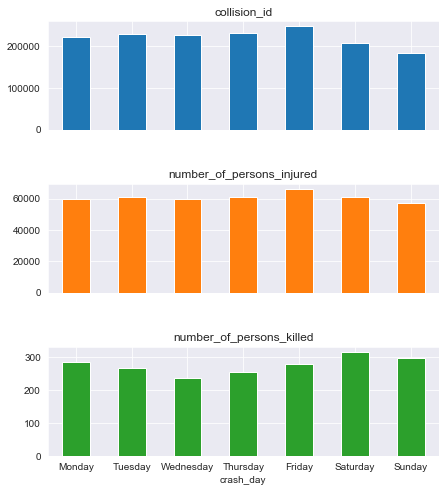

In [109]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

collision_station_comb.groupby(['crash_day']).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   }).reindex(cats). \
                                                                    reset_index().plot.bar(x='crash_day',
                                                                    subplots=True,rot=0,figsize=(7,8),legend=False)
plt.subplots_adjust(hspace=0.5)
plt.show()

- More Accidents occur on Fridays, perhaps because it's the start of weekend.People go to their homes(near by counties/states), get out for partying while the daily traffic congestion is still there

In [ ]:
# pd.DataFrame(collision_station_comb_2.contributing_factor_vehicle_1.value_counts(dropna=False)).to_csv('acc_reas.csv')

In [ ]:
# contributing_factor_lookup

In [ ]:
# pd.DataFrame(collision_station_comb_2.vehicle_type_code_1.value_counts()).to_csv('vehicle_type_lookup.csv')

In [ ]:
##########ANSWER 3 ###########

In [ ]:
# sns.set_style('darkgrid')
# df_2.plot(kind='bar',x='borough',subplots=True,rot=0,figsize=(5,10))#,layout=(2,3)
# plt.subplots_adjust(hspace=0.5)
# plt.show()

In [ ]:
collision_station_comb_2.isnull().sum()

In [ ]:
data_2018 = collision_station_comb_2.loc[collision_station_comb_2.crash_date<pd.datetime(2019,1,1)]

In [ ]:
data_2018_s = data_2018[['collision_id','borough','number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend','accident_reason']]

In [ ]:
sample_df=data_2018_s.sample(frac=0.30, random_state=123)

In [ ]:
X=sample_df[['collision_id','number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend']]#,'accident_reason'
y=sample_df[['borough']]

In [ ]:
# X=pd.get_dummies(X,columns=['accident_reason']
#                            ,prefix=['accident_reason'])

In [ ]:

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

In [ ]:
model = RandomForestClassifier()
# define the ovr strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X_train, y_train)
# make predictions
yhat = ovr.predict(X_test)

In [ ]:
print(accuracy_score(y_test,yhat))
print(classification_report(y_test,yhat))

In [ ]:
yhat_t=ovr.predict(X_train)
print(accuracy_score(y_train,yhat_t))
print(classification_report(y_train,yhat_t))

In [ ]:
data_2019 = collision_station_comb_2.loc[(collision_station_comb_2.crash_date<pd.datetime(2020,1,1)) & 
                                        (collision_station_comb_2.crash_date>=pd.datetime(2019,1,1))]

In [ ]:
data_2019.shape

In [ ]:
X_19=data_2019[['collision_id','number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend']]#,'accident_reason'
y_19=data_2019[['borough']]

In [ ]:
# X_19=pd.get_dummies(X_19,columns=['accident_reason']
#                            ,prefix=['accident_reason'])

In [ ]:
yhat_19=ovr.predict(X_19)

In [ ]:
print(accuracy_score(y_19,yhat_19))
print(classification_report(y_19,yhat_19))

In [ ]:
def tune_model(X,y):
    """Tuning the model to find best hyper parameters"""
    
    try:
        def acc_model(params):
            """Performing K Fold Cross Validation and Computing Accuracy Score for each fold"""
            
            try:
                clf = RandomForestClassifier(**params, class_weight='balanced', n_jobs=50)
                skf = StratifiedKFold(n_splits=5,random_state=123)
                f_scores_list = []
                for train_index, test_index in skf.split(data_x, data_y):
                    clf.fit(data_x.iloc[train_index].astype('float'), data_y.iloc[train_index])
                    result = clf.predict(data_x.iloc[test_index])
                    f_scores_list.append(accuracy_score(data_y.iloc[test_index], result))#, average='macro'
                return statistics.mean(f_scores_list)
            except:
                logging.info('Exception while executing acc_model')
                logging.exception('Exception in function acc_model')
                sys.exit(1)
        
        def objective(params):
            """objective function: minimising loss"""
            
            try:
                nonlocal best
                acc = acc_model(params)
                if acc > best:
                    best = acc
                #print('new f1-score:', best, params)
                return {'loss': 1-acc, 'status': STATUS_OK}
            except:
                logging.info('Exception while executing objective')
                logging.exception('Exception in function objective')
                sys.exit(1)


        def parameterTuning():
            """Performing Bayesian Optimisation for Hyper Parameter Tuning"""
            
            try:
            #     Random Forest parameter space
                param_space = {
                    'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=70, high=210, q=10)),#q=10
                    'max_depth': hp.choice('max_depth', [3,4,5,7,10,12,14,15,17,20,23,25,27,30,32,35,37,40,45,50,55]),#, 25, 30, 35, 40, 45, None]),
                    'criterion': hp.choice('criterion',['gini','entropy']),
                    'min_samples_split': hp.choice('min_samples_split', [0.0005,0.001,0.005,0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
                                }
                
                trials = Trials()
                params = fmin(objective, param_space, algo=tpe.suggest, max_evals=50, trials=trials)
                params = space_eval(param_space, params)
                return params
            except:
                logging.info('Exception while executing parameterTuning')
                logging.exception('Exception in function parameterTuning')
                sys.exit(1)
        
        data_x=X
        data_y=y
        best=0
        tuned_params = parameterTuning()
        return tuned_params
    except:
        logging.info('Exception while executing tune_model')
        logging.exception('Exception in function tune_model')
        sys.exit(1)

In [ ]:
params = tune_model(X_train,y_train)

In [ ]:
params

In [ ]:
model = RandomForestClassifier(**params)
# define the ovr strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X_train, y_train)
# make predictions
yhat = ovr.predict(X_test)

In [ ]:
print(accuracy_score(y_test,yhat))
print(classification_report(y_test,yhat))

In [ ]:
yhat_t=ovr.predict(X_train)
print(accuracy_score(y_train,yhat_t))
print(classification_report(y_train,yhat_t))

In [ ]:
data_2019 = collision_station_comb_2.loc[(collision_station_comb_2.crash_date<pd.datetime(2020,1,1)) & 
                                        (collision_station_comb_2.crash_date>=pd.datetime(2019,1,1))]

In [ ]:
data_2019.shape

In [ ]:
X_19=data_2019[['collision_id','number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend']] #,'accident_reason'
y_19=data_2019[['borough']]

In [ ]:
# X_19=pd.get_dummies(X_19,columns=['accident_reason']
#                            ,prefix=['accident_reason'])

In [ ]:
yhat_19=ovr.predict(X_19)

In [ ]:
print(accuracy_score(y_19,yhat_19))
print(classification_report(y_19,yhat_19))

In [ ]:
collision_station_comb_2.loc[collision_station_comb_2.crash_date < pd.datetime(2019,1,1)].shape

In [ ]:
data_2018 = collision_station_comb.loc[collision_station_comb.crash_date<pd.datetime(2019,1,1)]

In [ ]:
data_2018.loc[(data_2018.zip_code.isnull()) & (data_2018.borough.notnull())].shape

In [ ]:
data_2018.loc[(data_2018.zip_code.notnull()) & (data_2018.borough.isnull())].shape

In [ ]:
data_2018['zip_code'].astype(str).str[0:3]

In [ ]:
data_2018.loc[(data_2018.borough.isnull()) ][['borough','zip_code']].sample(100)

In [ ]:
data_2018.head(2)

In [ ]:
data_2018_s = data_2018[['collision_id','latitude_x','longitude_x',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend']]

In [ ]:
X=data_2018_s[['collision_id',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend']]
y=data_2018_s[['latitude_x','longitude_x']]

In [ ]:


# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

In [ ]:
# Train the model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error

# Fit a linear regression model on the training set


In [ ]:
model = LinearRegression().fit(X_train, y_train)
print (model)

y_hat = model.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_hat)
print("R2:", r2)

print(mean_absolute_error(y_test,y_hat))

In [ ]:
model = DecisionTreeRegressor().fit(X_train, y_train)
print (model)

y_hat = model.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_hat)
print("R2:", r2)

print(mean_absolute_error(y_test,y_hat))

In [ ]:
# model = RandomForestRegressor().fit(X_train, y_train)
# print (model)

# y_hat = model.predict(X_test)

# mse = mean_squared_error(y_test, y_hat)
# print("MSE:", mse)

# rmse = np.sqrt(mse)
# print("RMSE:", rmse)

# r2 = r2_score(y_test, y_hat)
# print("R2:", r2)

# print(mean_absolute_error(y_test,y_hat))

In [ ]:
collision_station_comb.shape

In [ ]:
lat_longs = collision_station_comb[['latitude_x','longitude_x']]
# lat_longs = collision_station_comb[['latitude_x','longitude_x','latitude_y','longitude_y']]

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [ ]:
# data_ind_log['latitude_x'] = np.log(lat_longs['latitude_x'])
# data_ind_log['longitude_x'] = np.log(lat_longs['longitude_x'] + 1 + min(lat_longs['longitude_x']))

# data_ind_log2=data_ind_log.replace([np.inf,-np.inf],np.nan)
# data_ind_log2.fillna(value=0,axis=0,inplace=True)

scaler = StandardScaler()
#scaler = MinMaxScaler() 
scaler.fit(lat_longs) 
#scaler.fit(data_ind_log2) 
data_ind_normalized = scaler.transform(lat_longs)

In [ ]:
collision_station_comb

In [ ]:
lat_longs

In [ ]:
from datetime import datetime
from sklearn.cluster import KMeans,DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:

#find best value for epsilon
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_ind_normalized)
distances, indices = nbrs.kneighbors(data_ind_normalized)

distances = np.sort(distances, axis=0)
distances = distances[:,1]


#sharpest drop i.e. curvature at 0.2, so we set eps=0.2.


In [ ]:
data_18_19=collision_station_comb_2.loc[(collision_station_comb_2.crash_date >= pd.datetime(2018,1,1)) &
                          (collision_station_comb_2.crash_date < pd.datetime(2020,1,1))]

In [ ]:
data_18_19.reset_index(inplace=True)

In [ ]:
lat_longs_18_19 = data_18_19[['latitude_x','longitude_x']]

In [ ]:
scaler = StandardScaler()
#scaler = MinMaxScaler() 
scaler.fit(lat_longs_18_19) 
#scaler.fit(data_ind_log2) 
data_ind_normalized = scaler.transform(lat_longs_18_19)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_ind_normalized)
distances, indices = nbrs.kneighbors(data_ind_normalized)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(lat_longs_18_19)
distances, indices = nbrs.kneighbors(lat_longs_18_19)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [ ]:
len(distances)

In [ ]:
plt.plot(distances)

plt.ylim(0,0.01)
plt.xlim(277805,277895)

In [ ]:
from sklearn.cluster import OPTICS

In [ ]:
m = OPTICS(max_eps = 0.006,min_samples = 2,algorithm = 'ball_tree',metric = 'haversine')
m.fit(np.radians(lat_longs_18_19))

In [ ]:
pd.DataFrame(m.labels_,columns=['cluster']).cluster.value_counts()

In [ ]:
print(datetime.now()) #started at 1:04 am in morning

In [ ]:
# m = DBSCAN(eps=0.004, min_samples=2,algorithm='ball_tree',metric = 'haversine')
# m.fit(np.radians(lat_longs_18_19))

In [ ]:
pd.DataFrame(m.labels_,columns=['cluster']).cluster.value_counts()

In [ ]:
dd

In [ ]:
lat_longs_18_19.head()

In [ ]:
coords = lat_longs_18_19.as_matrix(columns=['latitude_x', 'longitude_x'])    
#db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [ ]:
coords

In [ ]:
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian

In [ ]:
#db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
m = DBSCAN(eps=epsilon, min_samples=2,algorithm='ball_tree',metric = 'haversine')
m.fit(np.radians(coords))

In [ ]:
clusters = m.labels_

In [ ]:
pd.DataFrame(clusters,columns=['cluster']).cluster.value_counts()

In [ ]:
miles_per_radian = 3959 #6371.0088
epsilon = 1.5 / miles_per_radian

In [ ]:
m = DBSCAN(eps=epsilon, min_samples=2,algorithm='ball_tree',metric = 'haversine')
m.fit(np.radians(coords))

In [ ]:
pd.DataFrame(m.labels_,columns=['cluster']).cluster.value_counts()